In [47]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [48]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [49]:
# Save the input and target variables
print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [50]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()


In [51]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [52]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model

model = get_model()

In [53]:
# Print the model summary
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_59 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_60 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_61 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                

In [54]:
# Compile the model
history = model.compile(optimizer="Adam", loss="mse", metrics=["mae"])


In [55]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [56]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.7522 - mae: 0.6102


[0.6406691233317058, 0.6101719]

#### Plot the learning curves

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

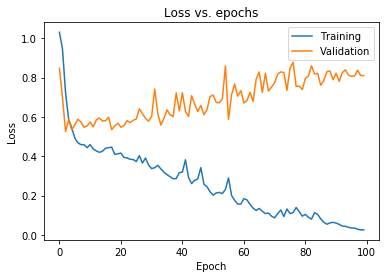

In [58]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [59]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [60]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [61]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)
print(model.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)              

In [62]:
# Compile the model
history = model.compile(optimizer="Adam", loss="mse", metrics=["mae"])



In [63]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)



In [64]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.5027 - mae: 0.4933


[0.35502221054501004, 0.49328512]

#### Plot the learning curves

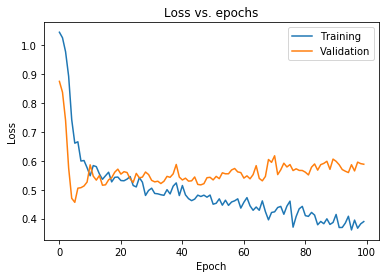

In [65]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [66]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Started training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Started epoch {epoch}....")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Started batch {batch}....")
    
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}....")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}....")        
        
    def on_train_end(self, logs=None):
          print("Finished training....")  
            
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Started testing....")

    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Started batch {batch}....")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}....")

    def on_test_end(self, logs=None):
          print("Finished testing....")
            
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Started prediction....")

    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Started batch {batch}....")
    
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}....")

    def on_predict_end(self, logs=None):
          print("Finished prediction....")               

In [67]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [68]:
# Compile the model
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])


#### Train the model with the callback

In [29]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, 
                    validation_split=0.15, batch_size=64, 
                    verbose=False, callbacks=[TrainingCallback()])



Started training....
Started epoch 0....
Training: Started batch 0....
Training: Finished batch 0....
Training: Started batch 1....
Training: Finished batch 1....
Training: Started batch 2....
Training: Finished batch 2....
Training: Started batch 3....
Training: Finished batch 3....
Training: Started batch 4....
Training: Finished batch 4....
Training: Started batch 5....
Training: Finished batch 5....
Finished epoch 0....
Started epoch 1....
Training: Started batch 0....
Training: Finished batch 0....
Training: Started batch 1....
Training: Finished batch 1....
Training: Started batch 2....
Training: Finished batch 2....
Training: Started batch 3....
Training: Finished batch 3....
Training: Started batch 4....
Training: Finished batch 4....
Training: Started batch 5....
Training: Finished batch 5....
Finished epoch 1....
Started epoch 2....
Training: Started batch 0....
Training: Finished batch 0....
Training: Started batch 1....
Training: Finished batch 1....
Training: Started batch

In [33]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=2, callbacks=[TestingCallback()])


Started testing....
Testing: Started batch 0....
Ttesting: Finished batch 0....
Testing: Started batch 1....
Ttesting: Finished batch 1....
45/1 - 0s - loss: 0.6575 - mae: 0.5924
Finished testing....


[0.5370874206225077, 0.59237987]

In [37]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])


Started prediction....
Prediction: Started batch 0....
Prediction: Finished batch 0....
Prediction: Started batch 1....
Prediction: Finished batch 1....
Finished prediction....


array([[-0.42433757],
       [ 0.564722  ],
       [ 0.5330205 ],
       [ 0.84385467],
       [ 1.5831168 ],
       [-0.38063005],
       [-0.96953946],
       [ 1.1160158 ],
       [-0.38844475],
       [ 0.4089203 ],
       [-0.95997864],
       [ 0.78631514],
       [ 1.2051291 ],
       [-0.726637  ],
       [-0.6861115 ],
       [ 0.81027675],
       [-0.53894776],
       [-0.46563593],
       [-0.5957221 ],
       [ 0.4944233 ],
       [-0.51147544],
       [ 1.0014225 ],
       [-0.47303423],
       [-0.42382613],
       [-0.60328203],
       [ 0.24535385],
       [-0.44675973],
       [-0.52879816],
       [ 1.3497424 ],
       [-0.49237835],
       [-0.674174  ],
       [-0.43711087],
       [ 1.736299  ],
       [-0.5286555 ],
       [ 1.5870057 ],
       [-0.38860202],
       [-0.3741999 ],
       [ 1.0073866 ],
       [-0.88146037],
       [-0.91340077],
       [ 0.8783267 ],
       [ 1.2839946 ],
       [ 0.12068531],
       [ 1.9958853 ],
       [-0.521999  ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [80]:
# Re-train the unregularised model


unregularised_model = get_model()
unregularised_model.compile(optimizer="Adam", loss="mse")
unregularised_history = unregularised_model.fit(train_data, train_targets, epochs=100,
                                               validation_split=0.15, batch_size=64, verbose=False,
                                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

In [81]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5230


0.3860411259863112

In [82]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2) 
regularised_model.compile(optimizer="Adam", loss="mse")
regularised_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                               validation_split=0.15, batch_size=64, verbose=False,
                                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])


In [83]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.4959


0.3909523606300354

#### Plot the learning curves

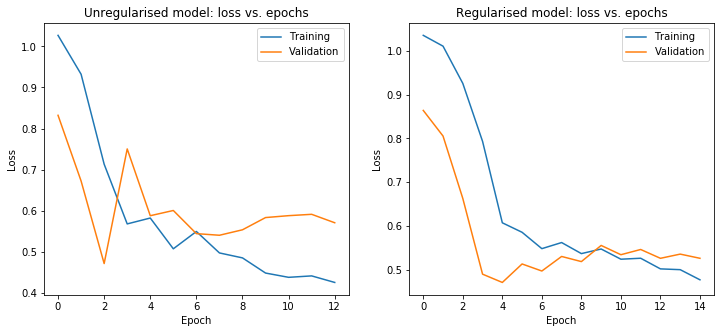

In [84]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unregularised_history.history['loss'])
plt.plot(unregularised_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(regularised_history.history['loss'])
plt.plot(regularised_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()